### Importowanie bibliotek

In [43]:
import json
import string
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import pearsonr

### Analiza nacechowania opinii

In [44]:
corpus_dir = ("./Opinie/PL")
corpus = PlaintextCorpusReader(corpus_dir, r".*\.txt")
documents = {}
for file_name in corpus.fileids():
    documents[file_name] = corpus.raw(file_name)
with open("./stopwords_pl.txt", "r", encoding="UTF-8") as tf:
    stoplist = tf.read().splitlines()
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = " ".join([word for word in word_tokenize(documents[key]) if word not in stoplist])  
docs = pd.DataFrame.from_dict(documents, orient='index')

In [45]:
docs['name'] = docs.index.map(lambda n: n.split("_"))
docs = pd.concat([docs, docs.name.apply(pd.Series)], axis=1)
docs = docs.drop(columns=['name'])
docs.columns = ['content', 'brand', 'model', 'score', 'sentiment_original', 'no']
docs['no'] = docs['no'].apply(lambda n: float(n.split(".")[0]))
docs = docs.set_index('no')
docs['score'] = docs['score'].astype(float)

In [46]:
pos_dict = pd.read_csv('./posdict_infl_final_sen.csv', sep=';', header=0)
neg_dict = pd.read_csv('./negdict_infl_final_sen.csv', sep=';', header=0)
sen_dict = pd.concat([pos_dict, neg_dict])
sen_dict = sen_dict.dropna(inplace=False)

In [47]:
def evaluate_sentiment(text):
    tokens = text.split()
    score = 0
    for token in tokens:
        if token in sen_dict['words'].values:
            score += sen_dict[sen_dict['words'] == token]['score'].values[0]
    return score / len(tokens) if len(tokens) > 0 else 0

In [48]:
docs['score_dict'] = docs['content'].apply(evaluate_sentiment)
docs['sentiment_dict'] = docs['score_dict'].apply(lambda c: "P" if c >=0 else "N")

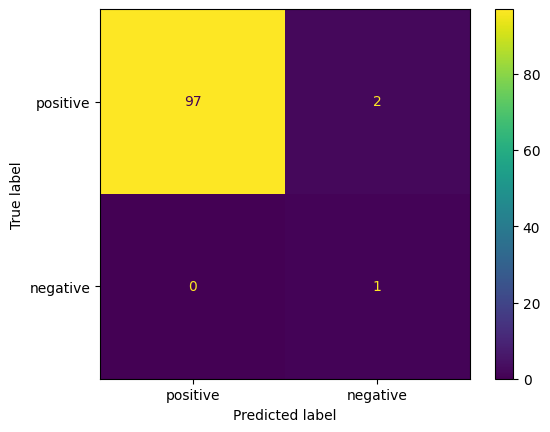

In [49]:
misclassified = confusion_matrix(docs['sentiment_original'], docs['sentiment_dict'], labels=["P", "N"])
ConfusionMatrixDisplay(misclassified, display_labels=["positive", "negative"]).plot()
report = classification_report(docs['sentiment_original'], docs['sentiment_dict'], labels=["P", "N"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
corr_coef = pearsonr(docs['score'], docs['score_dict'])

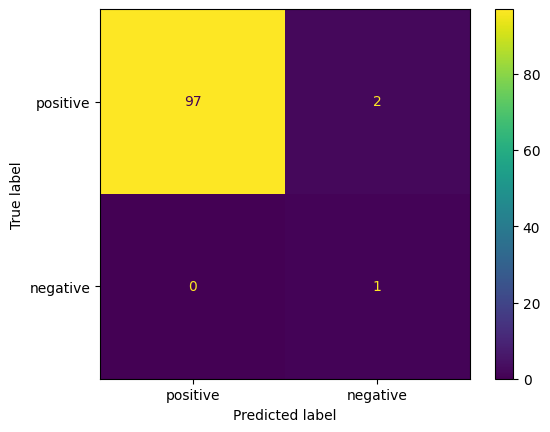

In [50]:
docs.to_csv("./sentiment_analysis_pl.csv", index=False, encoding="UTF-8")
report_df.to_csv("./sentiment_report_pl.csv", index=False, encoding="UTF-8")
ConfusionMatrixDisplay(misclassified, display_labels=["positive", "negative"]).plot().figure_.savefig("./confusion_matrix_pl.png")